In [68]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pickle
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch
from matplotlib import rc
import scipy.linalg as splin
from sklearn.manifold import TSNE

In [254]:
def openThing(file,py2 = False):
    if py2:
        with open(file,'rb') as fil:
            u = pickle._Unpickler(fil)
            u.encoding = 'latin1'
            thing = u.load()
    else:
        with open(file,'rb') as fil:
            thing = pickle.load(fil)
    return thing

def saveThing(thing,file):
    with open(file,'wb') as fil:
        pick = pickle.Pickler(fil,protocol=4)
        pick.dump(thing)
        pick.clear_memo()
    
def plot3D(px,py,pz,clist,emphPoints = [],cmap='plasma',shadow=False,useCMAP = True,xLabel='',yLabel='',zLabel='',savefig='',saveN = 1):
    
    elev = 30
    azim = 60

    viewVect = [np.cos(np.pi*180/elev)*np.sin(np.pi*180/azim),np.cos(np.pi*180/elev)*np.cos(np.pi*180/azim),np.cos(np.pi*180/elev)]
    
    thetalist = np.linspace(0,2*np.pi,saveN + 1)
    thetalist = thetalist[:-1]
    
    projMat = np.array([px,py])
    
    for idx in range(saveN):
        theta = thetalist[idx]
        rotMat = np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
        
        rotx,roty = np.dot(rotMat,projMat)
        rotz = pz
        clistRot = clist
        
        p = np.array([rotx,roty,rotz])
        dots = np.array(np.dot(viewVect,p))
        sort = dots.argsort()

        fig = plt.figure(figsize = (10,10))
        ax = fig.gca(projection='3d')

        Xdist = px.max() - px.min()
        Xcntr = (px.max() + px.min())/2.0
        Ydist = py.max() - py.min()
        Ycntr = (py.max() + py.min())/2.0
        Zdist = pz.max() - pz.min()
        Zcntr = (pz.max() + pz.min())/2.0

        dist = 0.55*max(Xdist,Ydist,Zdist)

        for p in emphPoints:
            ax.scatter([rotx[p]],[roty[p]],[rotz[p]],c='C1',s=200)
            if shadow:
                ax.scatter([rotx[p]],[roty[p]],[Zcntr - dist],c='black',alpha=0.5)
                ax.scatter([rotx[p]],[Ycntr + dist],[rotz[p]],c='black',alpha=0.5)
                ax.scatter([Xcntr - dist],[roty[p]],[rotz[p]],c='black',alpha=0.5)
        
        rotx = rotx[sort]
        roty = roty[sort]
        rotz = rotz[sort]
        clistRot = np.array(clistRot)[sort]
        
        if useCMAP:
            ax.scatter(rotx,roty,rotz,c=clistRot,edgecolor='black',linewidth=0.2,cmap = cmap)
        else:
            ax.scatter(rotx,roty,rotz,c=clistRot,edgecolor='black',linewidth=0.2)


        ax.set_xlim([Xcntr - dist, Xcntr + dist])
        ax.set_ylim([Ycntr - dist, Ycntr + dist])
        ax.set_zlim([Zcntr - dist, Zcntr + dist])

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])

        #ax.set_axis_off()
        #plt.show()

        if shadow:
            #fig = plt.figure(figsize = (10,10))
            #ax = fig.gca(projection='3d')
            #ax.view_init(30,-60)

            ax.scatter(rotx,roty,[Zcntr - dist for p in rotz],c='black',alpha=0.01)
            ax.scatter(rotx,[Ycntr + dist for p in roty],rotz,c='black',alpha=0.01)
            ax.scatter([Xcntr - dist for p in rotx],roty,rotz,c='black',alpha=0.01)

            ax.set_xlim([Xcntr - dist, Xcntr + dist])
            ax.set_ylim([Ycntr - dist, Ycntr + dist])
            ax.set_zlim([Zcntr - dist, Zcntr + dist])

            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_zticks([])

            #ax.set_axis_off()
        ax.set_xlabel(xLabel,fontsize=16)
        ax.set_ylabel(yLabel,fontsize=16)
        ax.set_zlabel(zLabel,fontsize=16)

        if savefig == '':
            plt.show()
        else:
            plt.savefig(savefig+str(idx)+'.png')
            plt.close()
    
def trianglePlot(arry,clist,emphPoints = [],dim=2,hideAxes = False):
    
    ranges = [arry[:,idx].max()-arry[:,idx].min() for idx in range(dim+1)]
    axesDist = 0.6*max(ranges)
    
    figs,axs = plt.subplots(nrows=dim,ncols=dim,figsize=(10,10))
    for row in range(dim-1,-1,-1):
        for col in range(dim-1,-1,-1):
            if col >= row:
                py = arry[:,row]
                px = arry[:,col+1]
                
                centerX = (px.max()+px.min())/2
                centerY = (py.max()+py.min())/2
                
                sc1 = axs[row,col].scatter(px,py,s=5,c=clist,edgecolor='black',linewidth=0.2, cmap='plasma')
                for p in emphPoints:
                    axs[row,col].scatter([px[0]],[py[0]],s=100,c='C1',edgecolor='black',linewidth=0.2)
                
                axs[row,col].set_xlim([centerX-axesDist,centerX+axesDist])
                axs[row,col].set_ylim([centerY-axesDist,centerY+axesDist])
                if (row != col) or (hideAxes == True):
                    axs[row,col].set_xticks([])
                    axs[row,col].set_yticks([])
                if row == col:
                    axs[row,col].set_ylabel('dir.'+str(row+1),fontsize=16)
                    axs[row,col].set_xlabel('dir.'+str(col+2),fontsize=16)
                axs[row,col].ticklabel_format(style='sci',scilimits=(-2,2),axis='both')
            else:
                axs[row,col].axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    
    
class Arrow3D(FancyArrowPatch):

    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [138]:
cmbParams = openThing('cmb_data/Params.pckl',py2=True)
cmbProj = openThing('cmb_data/proj.pckl',py2=True)
cmbImCol = openThing('cmb_data/imCol.pckl',py2=True)
planckCl = openThing('cmb_data/PlanckCl.pckl',py2=True)
planck_TT = openThing('cmb_data/planck_TT.pckl',py2=True)
planck_EE = openThing('cmb_data/planck_EE.pckl',py2=True)
planck_TE = openThing('cmb_data/planck_TE.pckl',py2=True)

isingParams = openThing('ising_data/params.pckl')
ising2x2Proj = openThing('ising_data/proj2.pckl')
ising4x4Proj = openThing('ising_data/proj4.pckl')
ising2_logProj = openThing('ising_data/proj2_log.pckl')
ising2x2_4repProj = openThing('ising_data/proj4_rep.pckl')
ising2x2_manyrepProj = openThing('ising_data/proj2_ManyRep.pckl')

mnistLabels = openThing('mnist_data/labels.pckl')
mnistProj = openThing('mnist_data/proj.pckl')
mnistProbs = openThing('mnist_data/probs.pckl')
mnistTSNEProj = openThing('mnist_data/tsneHellinger.pckl')
mnistKLProj = openThing('mnist_data/tsneKL.pckl')
sampleDigits = openThing('mnist_data/sampleDigits.pckl')

In [307]:
[code for code in cmbParams[0]]

['scalar_spectral_index(1)',
 'hubble',
 'omch2',
 'ombh2',
 're_optical_depth',
 'scalar_amp(1)']

CMB

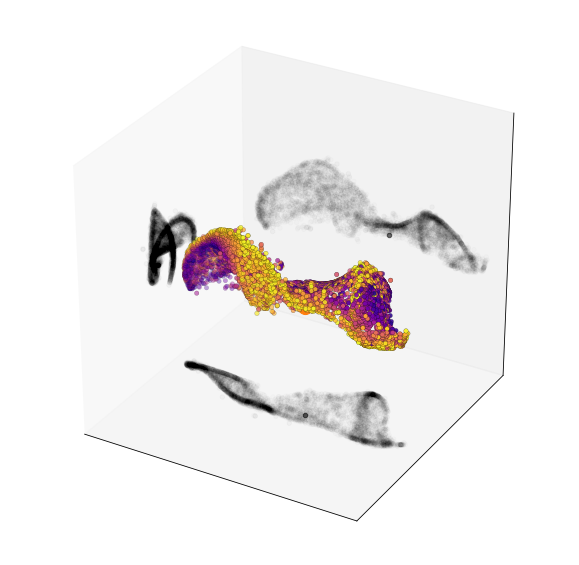

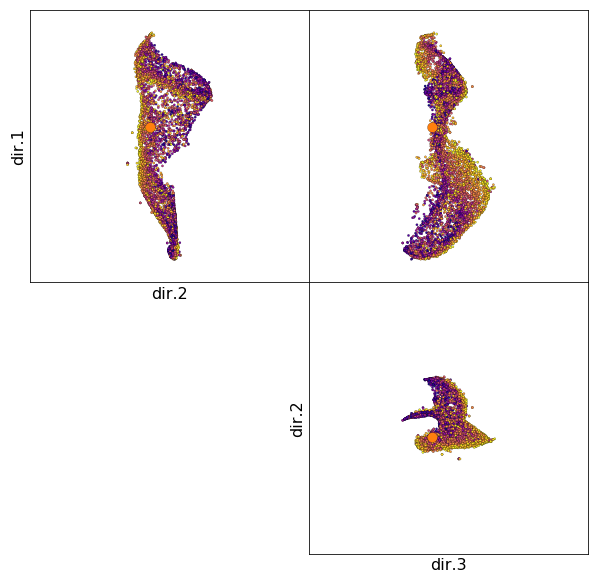

In [313]:
#3D plot of TSNE embedding
py = cmbTSNE[0][:,1]
px = -cmbTSNE[0][:,2]
pz = cmbTSNE[0][:,0]
clist = [np.log10(param['hubble']) for param in cmbParams]
plot3D(px,py,pz,clist,emphPoints=[0],shadow=True)
trianglePlot(np.array([px,py,pz]).T,clist,emphPoints=[0],dim=2,hideAxes=True)

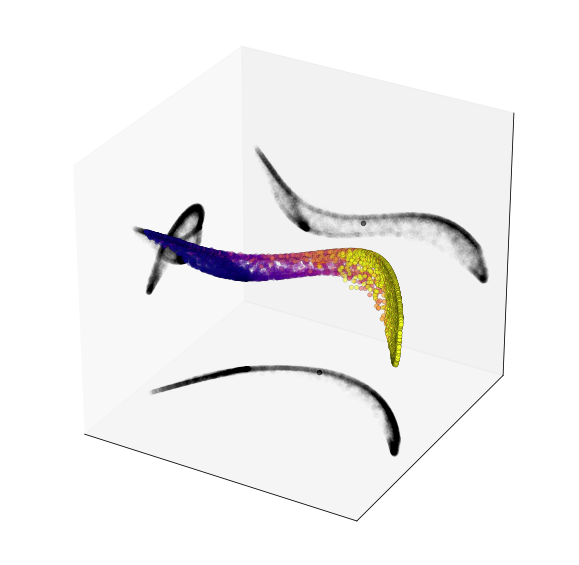

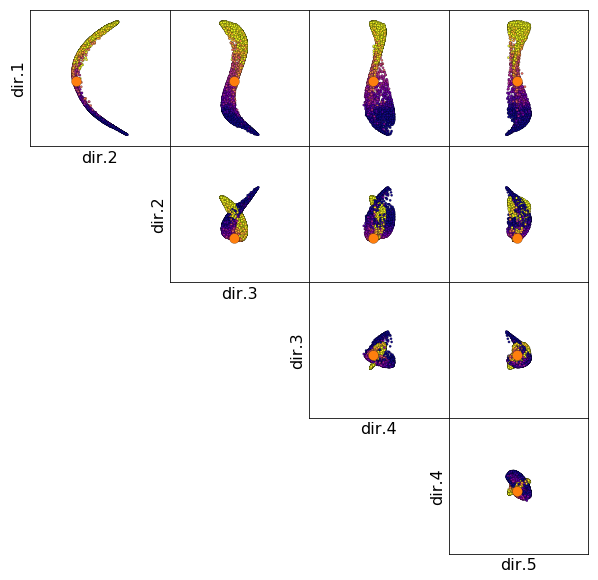

In [294]:
#3D plots
proj = cmbProj
px = proj[:,0]
py = -proj[:,1]
pz = proj[:,2]
clist = [np.log10(param['hubble']) for param in cmbParams]
plot3D(px,py,pz,clist,emphPoints=[0],shadow=True)
trianglePlot(proj,clist,dim=4,hideAxes=True,emphPoints=[0])

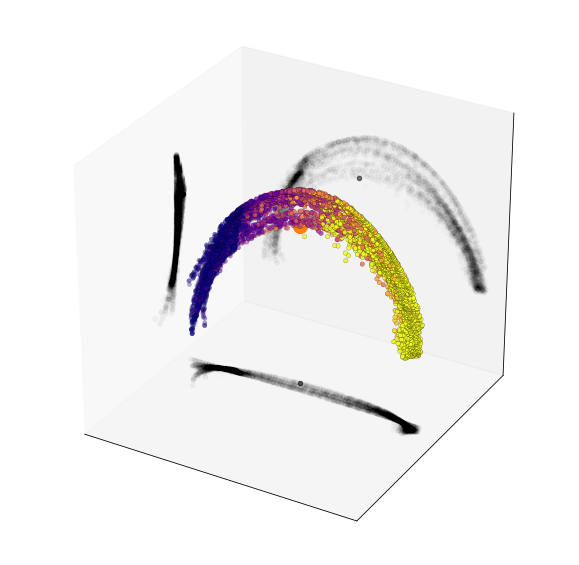

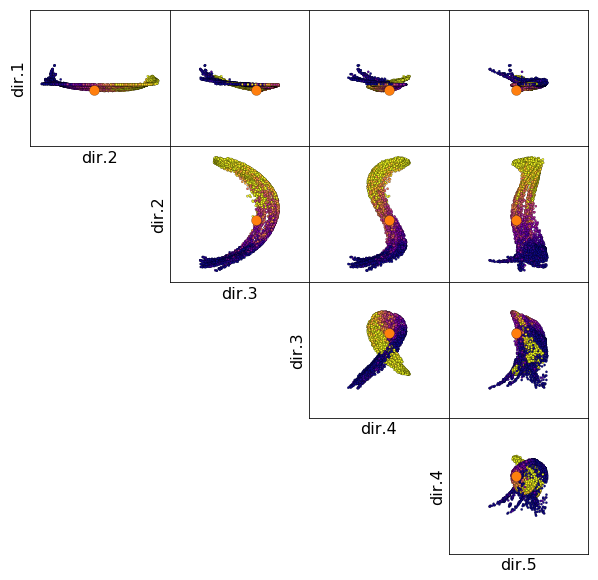

In [297]:
#3D plot of diffusion map
py = -projDiff[:,0]
px = projDiff[:,1]
pz = projDiff[:,2]
plot3D(px,py,pz,clist,emphPoints=[0],shadow=True)
trianglePlot(projDiff,clist,dim=4,hideAxes=True,emphPoints=[0])

-10.4230675657
-7.38300619236


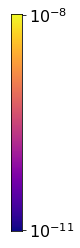

In [74]:
f = plt.figure(figsize=(1,4))

ax = f.add_subplot(111)
cMin = min(clist)
cMax = max(clist)

print(cMin)
print(cMax)

Z = np.array([-np.linspace(cMin,cMax,100) for i in range(5)]).T

ax.imshow(Z,cmap='plasma',interpolation='bilinear')

ax.set_xticks([])

ax.set_yticks([0,99])
ax.set_yticklabels([r'$10^{-8}$',r'$10^{-11}$'],fontsize=16)
#ax.set_title('A_s$',fontsize=16)
ax.yaxis.tick_right()

plt.show()

In [4]:
cmbDistances = openThing('cmb_data/distances.pckl',py2=True)
DDT = np.diag([0.0 for i in range(len(cmbDistances[0])+1)])
for i in range(len(cmbDistances)):
    for j in range(len(cmbDistances[i])):
        DDT[i][i+1+j] = abs(cmbDistances[i][j])
        DDT[i+1+j][i] = DDT[i][i+1+j]

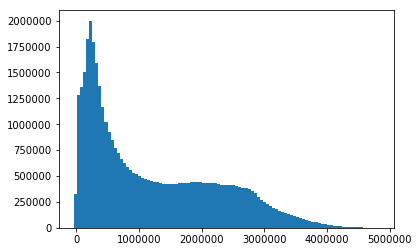

In [84]:
n,bins,patches = plt.hist(np.concatenate(DDT),bins=100)

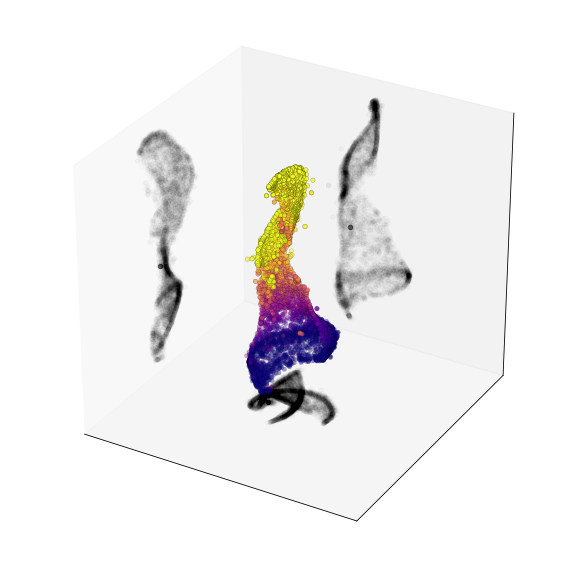

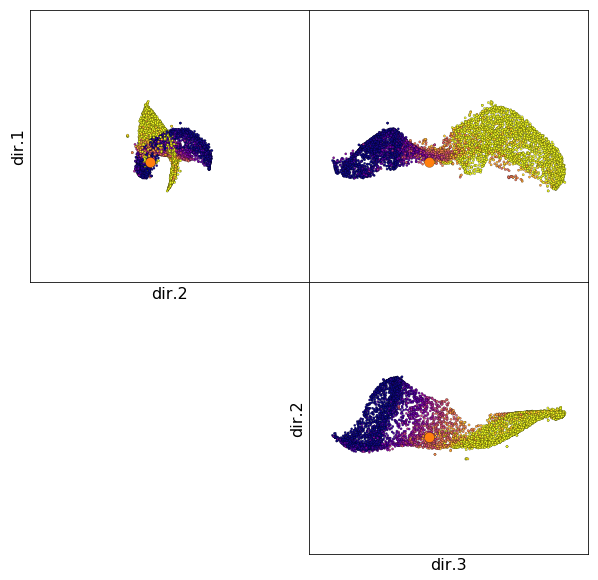

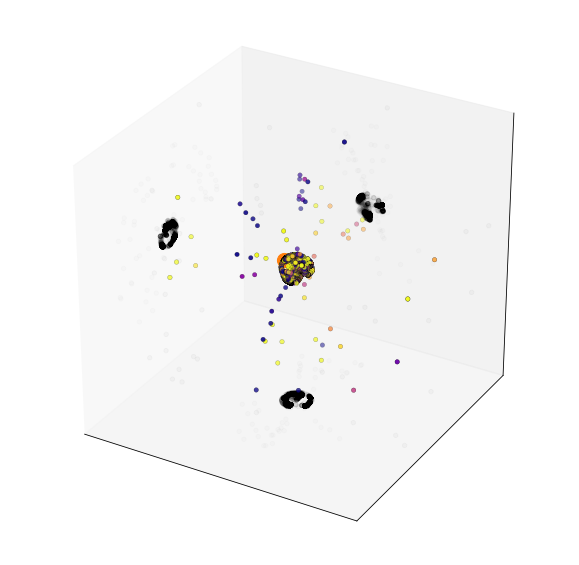

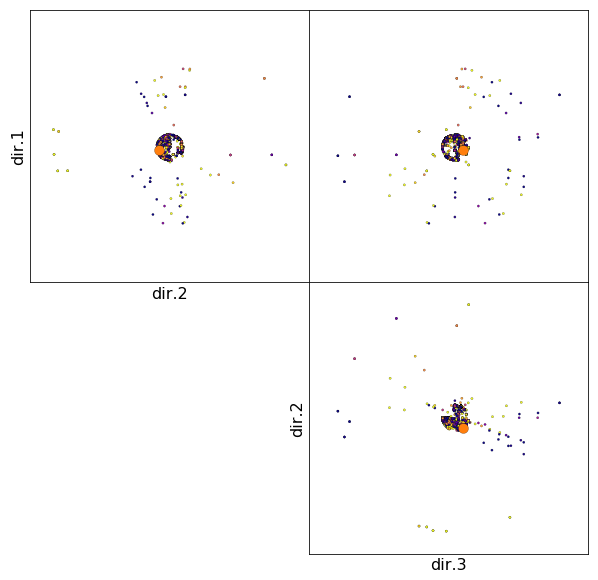

In [299]:
cmbTSNE = []
for per in [500,50000]:
    cmbTSNE_temp = TSNE(n_components=3,metric="precomputed",perplexity=per,learning_rate=100).fit_transform(abs(DDT))
    cmbTSNE.append(cmbTSNE_temp)
    py = cmbTSNE_temp[:,0]
    px = cmbTSNE_temp[:,1]
    pz = cmbTSNE_temp[:,2]
    plot3D(px,py,pz,clist,emphPoints=[0],shadow=True)
    trianglePlot(cmbTSNE_temp,clist,emphPoints=[0],dim=2,hideAxes=True)

In [ ]:
#Diffusion Map of CMB
epsilon = max(np.concatenate(DDT)/1.5)
L = np.exp(-abs(DDT)/epsilon)
D = np.diag([1/sum(row) for row in L])
M = np.dot(D,L)
wh,vh = splin.eigh(M,eigvals=(len(DDT)-7,len(DDT)-1))
eigs = wh[[-i for i in range(1,len(wh)+1)]]
eigv = vh[:,[-i for i in range(1,len(wh)+1)]]
projDiff = np.sqrt(eigs)*eigv

In [301]:
saveThing(cmbTSNE[0],'cmb_data/TSNE.pckl')

In [219]:
saveThing(projDiff,'cmb_data/projDiff.pckl')

In [273]:
cmbNames = [code for code in cmbParams[0]]

In [276]:
cmbNames

['scalar_spectral_index(1)',
 'hubble',
 'omch2',
 'ombh2',
 're_optical_depth',
 'scalar_amp(1)']

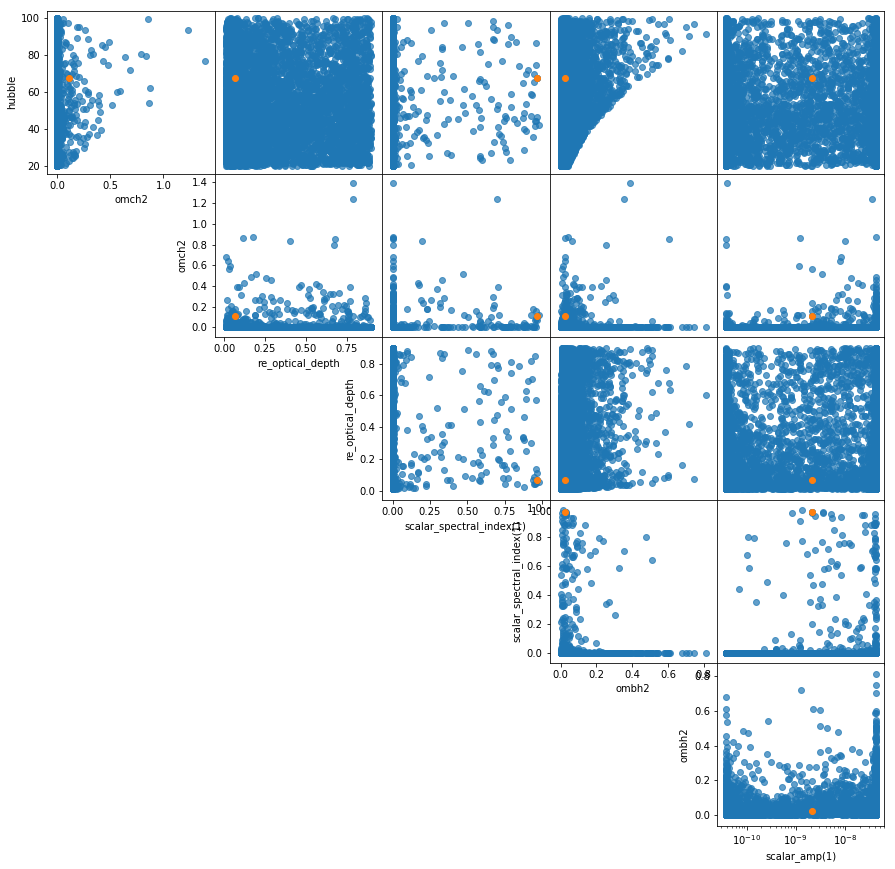

In [293]:
keys = ['hubble','omch2','re_optical_depth','scalar_spectral_index(1)','ombh2','scalar_amp(1)']
gSize = len(keys)-1
fig,axes = plt.subplots(nrows=gSize,ncols=gSize,figsize=(15,15))
for row in range(gSize):
    for col in range(gSize):
        if col >= row:
            py = [param[keys[row]] for param in cmbParams]
            px = [param[keys[col+1]] for param in cmbParams]
            
            if keys[row] == 'scalar_amp(1)':
                axes[row,col].set_yscale('log')
            if keys[col+1] == 'scalar_amp(1)':
                axes[row,col].set_xscale('log')
            
            img = axes[row,col].scatter(px,py,alpha=0.7,c='C0')
            img2 = axes[row,col].scatter([px[0]],[py[0]],c='C1')
            
            if row != col:
                axes[row,col].set_xticks([])
                axes[row,col].set_yticks([])
            else:
                axes[row,col].set_xlabel(keys[col+1])
                axes[row,col].set_ylabel(keys[row])
            #axes[row,col].ticklabel_format(style='sci',scilimits=(-2,2),axis='both')
        else:
            axes[row,col].axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

Ising

2x2 Ising


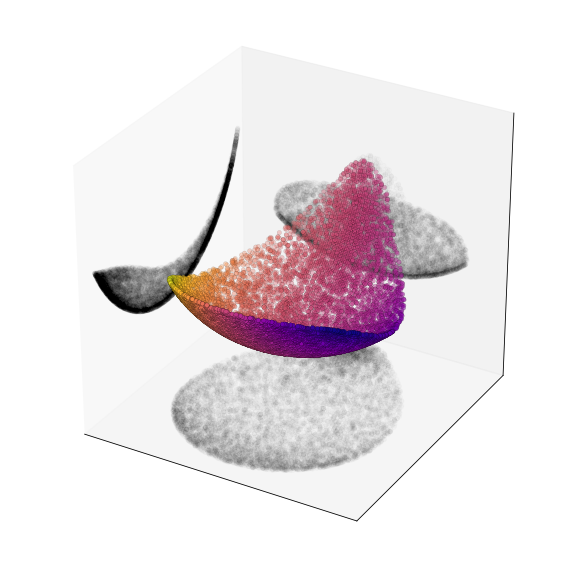

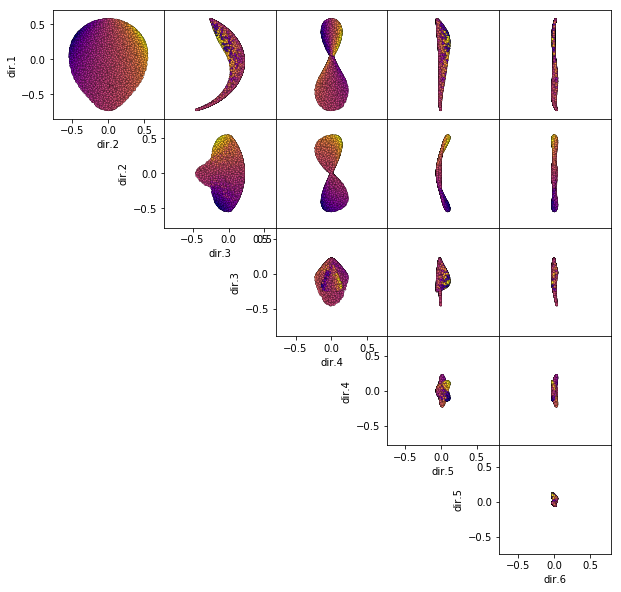

In [240]:
print('2x2 Ising')
proj = ising2x2Proj
py = -proj[:,0]
px = -proj[:,1]
pz = -proj[:,2]
clist = [param['field'] for param in isingParams]
plot3D(px,py,pz,clist,shadow=True)
trianglePlot(proj,clist,dim=5)

#plt.figure(figsize=(8,8))
#plt.plot([np.sqrt(sum(row**2)/len(row)) for row in proj.T],[(max(row) - min(row)) for row in proj.T],marker='o',label='2x2 Ising, Hypersphere Embedding')
#plt.legend()
#plt.xlabel('Manifold Variance')
#plt.ylabel('Manifold Length')
#plt.show()


In [222]:
isingDistances = -np.log(openThing('ising_data/DDT4x4.pckl'))

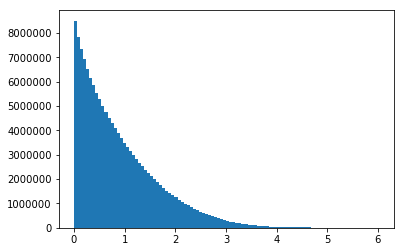

In [223]:
n,bins,patches = plt.hist(np.concatenate(isingDistances),bins=100)

In [224]:
isingTSNE = TSNE(n_components=3,metric="precomputed").fit_transform(abs(isingDistances))

In [231]:
saveThing(isingTSNE,'ising_data/TSNE.pckl')

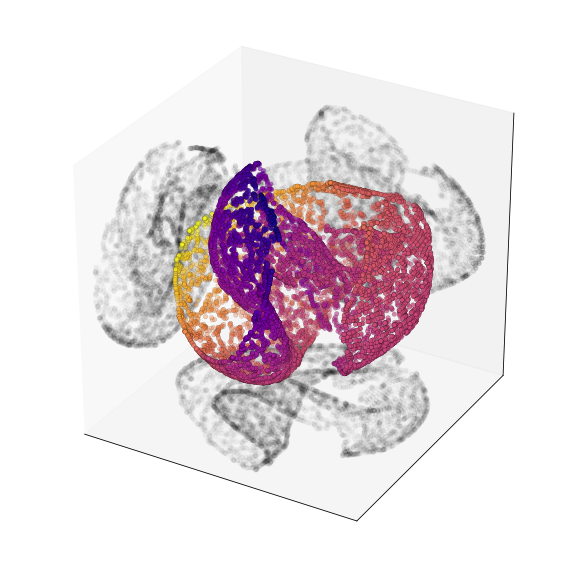

In [225]:
#3D plot of TSNE embedding
px = isingTSNE[:,0]
py = isingTSNE[:,1]
pz = isingTSNE[:,2]
plot3D(px,py,pz,clist,shadow=True)

In [236]:
#Diffusion Map of CMB
epsilon = max(np.concatenate(isingDistances)/20)
L = np.exp(-abs(isingDistances)/epsilon)
D = np.diag([1/sum(row) for row in L])
M = np.dot(D,L)
wh,vh = splin.eigh(M,eigvals=(len(isingDistances)-7,len(isingDistances)-1))
eigs = wh[[-i for i in range(1,len(wh)+1)]]
eigv = vh[:,[-i for i in range(1,len(wh)+1)]]
projDiffIsing = np.sqrt(eigs)*eigv

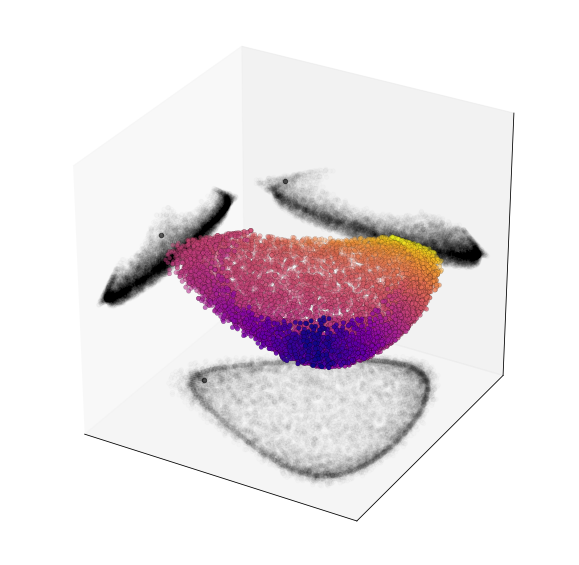

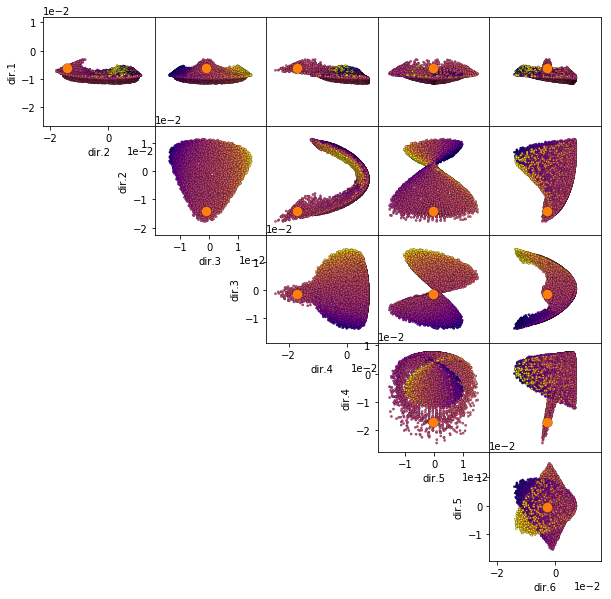

In [239]:
#3D plot of diffusion map
py = projDiffIsing[:,2]
px = projDiffIsing[:,1]
pz = projDiffIsing[:,0]
plot3D(px,py,pz,clist,emphPoints=[0],shadow=True)
trianglePlot(projDiffIsing,clist,dim=5,emphPoints=[0])

In [238]:
saveThing(projDiffIsing,'ising_data/projDiff.pckl')

In [ ]:
f = plt.figure(figsize=(1,4))

ax = f.add_subplot(111)
cMin = min(clist)
cMax = max(clist)

Z = np.array([-np.linspace(cMin,cMax,100) for i in range(5)]).T

ax.imshow(Z,cmap='plasma',interpolation='bilinear')

ax.set_xticks([])

ax.set_yticks([0,49,99])
ax.set_yticklabels([1.3,0,-1.3],fontsize=16)
#ax.set_title('field',fontsize=16)
ax.yaxis.tick_right()

plt.show()

In [ ]:
print('4x4 Ising')
proj = ising4x4Proj
py = proj[:,0]
px = -proj[:,1]
pz = -proj[:,2]
clist = [param['field'] for param in isingParams]
plot3D(px,py,pz,clist,shadow=True)
#trianglePlot(np.array([px,py,pz]).T,clist)

In [ ]:
print('2x2, 4 replica Ising')
proj = ising2x2_4repProj
py = proj[:,0]
px = -proj[:,1]
pz = -proj[:,2]
clist = [param['field'] for param in isingParams]
plot3D(px,py,pz,clist,shadow=True)
#trianglePlot(np.array([px,py,pz]).T,clist)

In [ ]:
print('2x2, many replica Ising')
proj = ising2x2_manyrepProj
py = proj[:,2]
px = proj[:,1]
pz = proj[:,0]
clist = [param['field'] for param in isingParams]
plot3D(px,py,pz,clist,shadow=True)
#trianglePlot(np.array([px,py,pz]).T,clist)

2x2, Intensive Ising


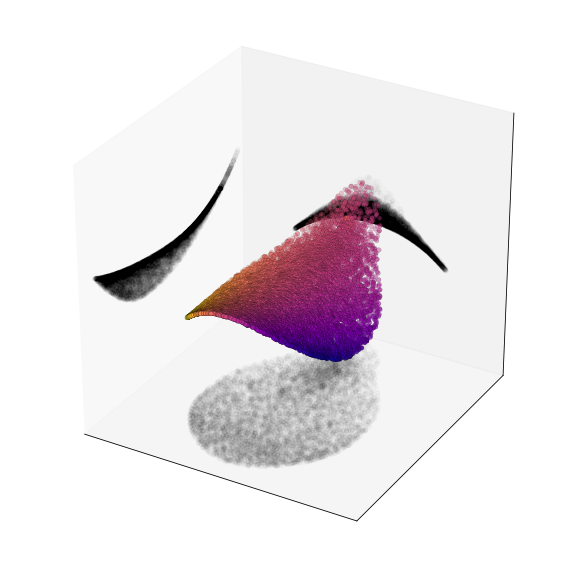

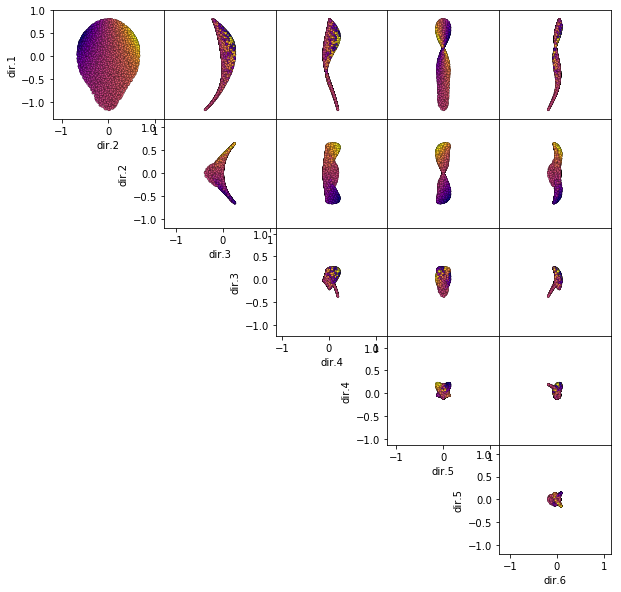

In [241]:
print('2x2, Intensive Ising')
proj = ising2_logProj
py = -proj[:,0]
px = -proj[:,1]
pz = -proj[:,2]
clist = [param['field'] for param in isingParams]
plot3D(px,py,pz,clist,shadow=True,emphPoints=[0])
trianglePlot(proj,clist,dim=5)

MNIST

In [ ]:
proj = mnistProj
px = -proj[:,0]
py = -proj[:,1]
pz = -proj[:,2]
clist = mnistLabels
plot3D(px,py,pz,clist,shadow=True)
#trianglePlot(proj,clist)

In [ ]:
proj = mnistKLProj
px = proj[:,0]
py = proj[:,1]
pz = proj[:,2]
clist = mnistLabels
plot3D(px,py,pz,clist,shadow=True)
#trianglePlot(proj,clist)

In [ ]:
fig = plt.figure(figsize=(20,20))
ax = fig.gca(projection='3d')

# draw sphere
u, v = np.mgrid[0:2*np.pi:100j, 0:np.pi:100j]
radius = 0.5
x = radius * np.cos(u)*np.sin(v)
y = radius * np.sin(u)*np.sin(v)
z = radius * np.cos(v)

for i in range(1,60,2):
    for j in range(1,20,2):
        x_loc = 1.3*i
        y_loc = 0
        z_loc = 1.3*j
        
        xp = x + x_loc
        yp = y + y_loc
        zp = z + z_loc
        
        up = np.random.choice([True,False])
        if up:
            arrowDir = [-1.8*radius+z_loc,2.8*radius+z_loc]
            arrowCol = 'red'
        else:
            arrowDir = [1.8*radius+z_loc,-2.8*radius+z_loc]
            arrowCol = 'blue'
        
        a = Arrow3D([x_loc, x_loc], [y_loc, y_loc], arrowDir, mutation_scale=20,lw=3, arrowstyle="-|>", color=arrowCol, alpha=0.7)
        ax.add_artist(a)

        ax.plot_wireframe(xp, yp, zp, color="black",rstride=5, cstride=5, alpha=0.1)

ax.set_zlim([0,30])
ax.set_xlim([0,30])
ax.set_ylim([0,30])
        
ax.axis('off')
#ax.axis('equal')

#ax.set_xlabel('x')
#ax.set_ylabel('y')
#ax.set_zlabel('z')

ax.view_init(0,90)

plt.show()


In [ ]:
for digit in sampleDigits:
    plt.figure(figsize=(1,1))
    plt.imshow([digit[28*i:28*(i+1)] for i in range(28)],cmap='Greys')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [ ]:
nearest = [p['nearest'] for p in isingParams]

In [ ]:
min(nearest)

In [ ]:
max(nearest)